In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from collections import OrderedDict

# Load the prepared training set

In [2]:
train = pd.read_csv("train.csv", header=0)
test = pd.read_csv("test.csv", header=0)
validate = pd.read_csv("validate.csv", header=0)

### Arrange the data sets

In [3]:
X_train = train.drop(['Vote'],1)
Y_train = train.Vote
X_test = test.drop(['Vote'],1)
Y_test = test.Vote
X_validate = validate.drop(['Vote'],1)
Y_validate = validate.Vote

# Train at least one generative model and one clustering model

My mission is to find the most stable\strong coalision. That is, find p parties that will represnt at least 51% of the votes, and will have the following properties: relatively homogeneous with respect to the
participating parties, and very much different from the opposition.

### First step - clustering using KMeans for data exploration

Since I need p parties with more than 51% of the vote, I will start with k=2

In [4]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

In [5]:
kmeans.labels_

array([0, 0, 0, ..., 0, 1, 1], dtype=int32)

In [6]:
kmeans.cluster_centers_

array([[  4.82426901e-01,   6.02483498e-02,   1.04423017e-01,
          1.69165598e-01,  -2.76103451e-01,   2.85191851e+02,
          2.00564086e-02,   1.69225948e-02,   1.94296459e-02,
          1.97430273e-02,   2.00564086e-02,   0.00000000e+00,
          2.86869320e+00,   1.21936697e+00],
       [  4.31400153e-01,  -6.36237561e-02,  -9.53015952e-02,
         -1.78195158e-01,   2.95191002e-01,   1.25186499e+02,
          1.88679245e-02,   2.31399074e-02,   1.49519402e-02,
          1.77999288e-02,   2.13599146e-02,   0.00000000e+00,
          3.41153435e+00,   7.18761125e-01]])

Calculate the size of every party in each cluster:

In [7]:
cluster_a = {'Purples':0, 'Browns':0, 'Greens':0, 'Blues':0, 'Whites':0, 'Pinks':0, 'Reds':0,
       'Oranges':0, 'Yellows':0, 'Greys':0}
cluster_b = {'Purples':0, 'Browns':0, 'Greens':0, 'Blues':0, 'Whites':0, 'Pinks':0, 'Reds':0,
       'Oranges':0, 'Yellows':0, 'Greys':0}
total_votes = {'Purples':0, 'Browns':0, 'Greens':0, 'Blues':0, 'Whites':0, 'Pinks':0, 'Reds':0,
       'Oranges':0, 'Yellows':0, 'Greys':0}
parties = Y_train.unique()

In [8]:
for i in range(len(Y_train)):
    for party in parties:
        if Y_train[i]==party:
            total_votes[party] = total_votes[party]+1
            if kmeans.labels_[i]==1:
                cluster_a[party]= cluster_a[party]+1
            else:
                cluster_b[party]= cluster_b[party]+1
                

Plot the 2 clusters:

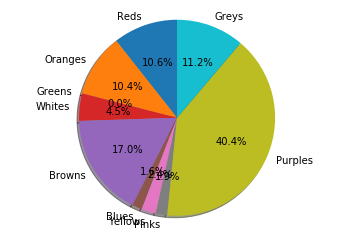

In [9]:
labels_a = cluster_a.keys()
sizes_a = cluster_a.values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes_a, explode=[0]*len(sizes_a), labels=labels_a, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

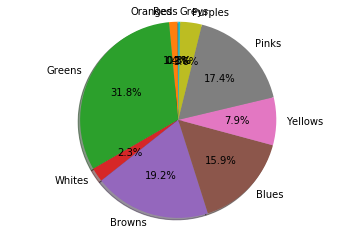

In [10]:
labels_b = cluster_b.keys()
sizes_b = cluster_b.values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes_b, explode=[0]*len(sizes_b), labels=labels_b, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [11]:
od_a = OrderedDict(sorted(cluster_a.items(), key=lambda x:x[1], reverse=True))
od_a

OrderedDict([('Purples', 1135),
             ('Browns', 477),
             ('Greys', 315),
             ('Reds', 299),
             ('Oranges', 291),
             ('Whites', 127),
             ('Yellows', 67),
             ('Pinks', 53),
             ('Blues', 46),
             ('Greens', 0)])

In [12]:
od_b = OrderedDict(sorted(cluster_b.items(), key=lambda x:x[1], reverse=True))
od_b

OrderedDict([('Greens', 1015),
             ('Browns', 614),
             ('Pinks', 555),
             ('Blues', 508),
             ('Yellows', 252),
             ('Purples', 114),
             ('Whites', 74),
             ('Oranges', 44),
             ('Greys', 10),
             ('Reds', 4)])

In [13]:
total_a = sum(cluster_a.values())
total_a

2810

In [14]:
total_b = sum(cluster_b.values())
total_b

3190

In [15]:
total_b - total_a

380

In [16]:
total_votes_ordered = OrderedDict(sorted(total_votes.items(), key=lambda x:x[1], reverse=True))
total_votes_ordered

OrderedDict([('Purples', 1249),
             ('Browns', 1091),
             ('Greens', 1015),
             ('Pinks', 608),
             ('Blues', 554),
             ('Oranges', 335),
             ('Greys', 325),
             ('Yellows', 319),
             ('Reds', 303),
             ('Whites', 201)])

An optional coalition could include: Purples, Browns, Greys, Reds, Oranges

In [17]:
total = sum(total_votes.values())
(total_votes['Purples'] + total_votes['Browns'] + total_votes['Greys']+ total_votes['Reds']+ total_votes['Oranges'])*100/total

55

It seems that it's a close call, With only 380 votes in favor of the Greens' coalition.
Also, it seems like the Browns are equaly likely to end up in both coalitions.
However, when examening the total results, the Purples seem more likely to succeed in building the coalition.

### Second step - Identify the leading features for each party

In [18]:
X_train.dtypes

Number_of_valued_Kneset_members                         float64
Yearly_IncomeK                                          float64
Overall_happiness_score                                 float64
Avg_Satisfaction_with_previous_vote                     float64
Garden_sqr_meter_per_person_in_residancy_area           float64
Weighted_education_rank                                 float64
Number_of_valued_Kneset_members_isNull                    int64
Yearly_IncomeK_isNull                                     int64
Overall_happiness_score_isNull                            int64
Avg_Satisfaction_with_previous_vote_isNull                int64
Garden_sqr_meter_per_person_in_residancy_area_isNull      int64
Weighted_education_rank_isNull                            int64
Most_Important_Issue_int                                  int64
Will_vote_only_large_party_int                            int64
dtype: object

In [19]:
features_means = {'Number_of_valued_Kneset_members':0, 'Yearly_IncomeK':0, 'Overall_happiness_score':0, 'Avg_Satisfaction_with_previous_vote':0, 'Garden_sqr_meter_per_person_in_residancy_area':0, 'Weighted_education_rank':0, 'Most_Important_Issue_int':0}

I now need to calculate the wht features are unique for each party. That is, statisticaly speaking, what features are relatively extreme.

In [46]:
a = train.groupby(['Vote'])['Number_of_valued_Kneset_members'].mean()
# sorted(a, key=lambda x:x[1], reverse=True)
a

Vote
Blues      0.633492
Browns     0.231745
Greens     0.636334
Greys      0.247086
Oranges    0.269199
Pinks      0.286085
Purples    0.632579
Reds       0.327583
Whites     0.324363
Yellows    0.635081
Name: Number_of_valued_Kneset_members, dtype: float64

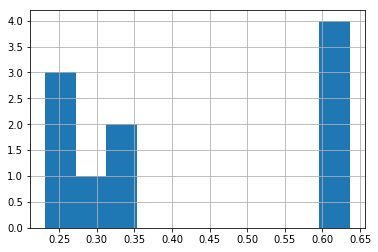

In [21]:
train.groupby(['Vote'])['Number_of_valued_Kneset_members'].mean().hist()

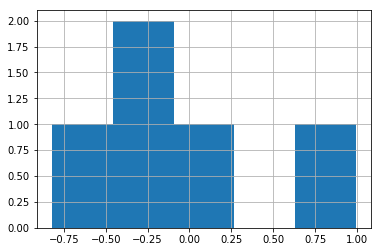

In [22]:
train.groupby(['Vote'])['Yearly_IncomeK'].mean().hist()

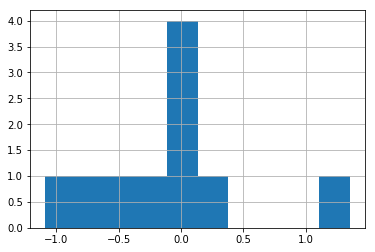

In [23]:
train.groupby(['Vote'])['Overall_happiness_score'].mean().hist()

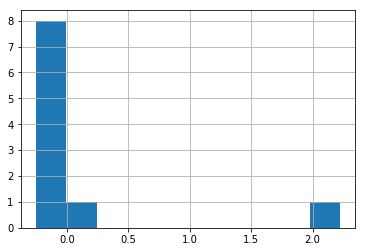

In [24]:
train.groupby(['Vote'])['Avg_Satisfaction_with_previous_vote'].mean().hist()

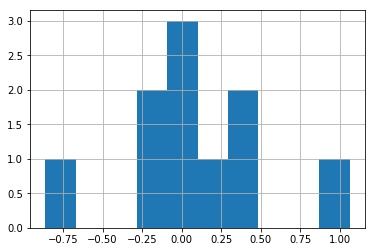

In [25]:
train.groupby(['Vote'])['Garden_sqr_meter_per_person_in_residancy_area'].mean().hist()

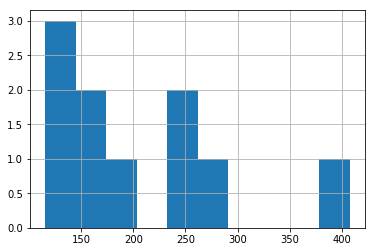

In [26]:
train.groupby(['Vote'])['Weighted_education_rank'].mean().hist()

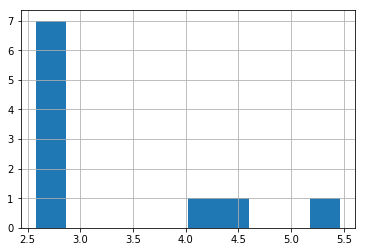

In [27]:
train.groupby(['Vote'])['Most_Important_Issue_int'].mean().hist()